## N-gram Language Models: Predicting the Next Word

Before we dive into Transformers, let’s step back in time and look at their ancestor: **N-gram models**.

An **N-gram** is simply a sequence of **N words** that appear together in a text. The core idea is to predict the next word in a sequence by looking at the words that came before it.

The probability of the next word `w_t` is estimated based on the last `(N-1)` words, which we call the **context**. This is formally written as:

$$
P(w_t \mid w_{t-(N-1)}, \ldots, w_{t-1})
$$

- **Bigram (N=2):** Considers the **previous word** to predict the next. `P(word | previous_word)`
- **Trigram (N=3):** Considers the **previous two words**. `P(word | word_before_previous, previous_word)`
- **4-gram (N=4):** Considers the **previous three words**, and so on.

### How does it work? By Counting!

The model calculates this probability by counting occurrences in the text:

$$
P(w_t | \text{context}) = \frac{\text{Count}(\text{context}, w_t)}{\text{Count}(\text{context})}
$$

In simple terms: we count how many times we've seen the whole phrase and divide it by the number of times we've seen the context.

In [1]:
!pip install re

ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re


In [2]:
!pip install ipywidgets

In [3]:
import re
from collections import defaultdict, Counter
import ipywidgets as widgets
from IPython.display import display, Markdown, HTML
import matplotlib.pyplot as plt
import numpy as np

# Expanded, tailored paragraph
text = """
Every morning, the baker bakes bread, pies, and cakes for the town. Every morning, the florist arranges tulips, roses, and lilies for the shop. Every morning, the barista brews coffee, tea, and cocoa for the café. Every evening, the baker closes the shop and walks home. Every evening, the florist waters the plants and turns off the lights. Every evening, the barista stacks the cups and sweeps the floor. On weekends, the baker visits the farmer’s market near the river. On weekends, the florist meets friends at the park with a picnic basket. On weekends, the barista goes hiking along the sunny hillside trail. When it rains, the baker reads by the window. When it rains, the florist sketches flower designs. When it rains, the barista practices guitar songs by the fire.
"""

# Tokenize text
tokens = re.findall(r"\b\w+\b", text.lower())

def get_context_counts(tokens, n):
    """Builds a dictionary of context -> next word counts."""
    ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
    context_counts = defaultdict(Counter)
    for gram in ngrams:
        context = gram[:-1]
        next_word = gram[-1]
        context_counts[context][next_word] += 1
    return context_counts

def plot_context_distribution(context_counts, plot_context):
    """Plots the probability distribution for a given context."""
    next_words = context_counts.get(plot_context, {})

    fig, ax = plt.subplots(figsize=(8, 4))

    if not next_words:
        ax.text(0.5, 0.5, "Context not found in model.", ha='center', va='center', fontsize=12)
        ax.set_title(f"Cannot Predict From Context: {plot_context}")
        ax.set_xticks([])
        ax.set_yticks([])
    else:
        # Show top 5 options only
        items = sorted(next_words.items(), key=lambda x: x[1], reverse=True)[:5]
        words, freqs = zip(*items)

        # Calculate probabilities
        total_freq = sum(next_words.values())
        probs = np.array(freqs) / total_freq

        bars = ax.bar(words, probs, color='royalblue')
        ax.set_ylabel('Probability')
        ax.set_ylim(0, 1.1)
        ax.set_title(f"Next Word Probabilities for Context: {plot_context}")

        # Add probability labels on top of bars
        for bar, p in zip(bars, probs):
            height = bar.get_height()
            ax.annotate(f'{p:.2f}', xy=(bar.get_x() + bar.get_width() / 2, height),
                        xytext=(0, 3), textcoords="offset points", ha='center', va='bottom', fontsize=9)
    plt.tight_layout()
    plt.show()

def generate_text_stepwise(context_counts, start_context, n, steps):
    """
    Generates text up to a specific step and returns the final text and the
    context used for the last prediction.
    """
    output_tokens = list(start_context)

    # The context for plotting is the one that PREDICTS the next word.
    # At step 0, we use the initial context to predict word 1.
    context_for_plotting = tuple(output_tokens[-(n-1):]) if n > 1 else tuple()

    for i in range(steps):
        # Define the context for the current prediction
        current_context = tuple(output_tokens[-(n-1):]) if n > 1 else tuple()
        context_for_plotting = current_context # This will be the context for the i-th word

        possible_next_words = context_counts.get(current_context, {})

        if not possible_next_words:
            output_tokens.append("[END]")
            break

        # Choose the most likely next word
        next_word = max(possible_next_words, key=possible_next_words.get)
        output_tokens.append(next_word)

    # Format the output with HTML
    start_html = ' '.join([f'<b style="color:#1a4b8a">{w}</b>' for w in start_context])
    generated_html = ' '.join([f'<span style="color:green">{w}</span>' for w in output_tokens[len(start_context):]])

    final_html = f'<div style="font-size:1.2em;line-height:1.6;">{start_html} {generated_html}</div>'

    return final_html, context_for_plotting

# --- WIDGET SETUP ---

preset_contexts = [
    ('every', 'morning', 'the', 'baker'),
    ('on', 'weekends', 'the', 'florist'),
    ('when', 'it', 'rains', 'the', 'barista'),
    ('every', 'evening', 'the')
]
preset_strs = [ ' '.join(ctx) for ctx in preset_contexts ]

context_dropdown = widgets.Dropdown(
    options=list(zip(preset_strs, preset_contexts)),
    value=preset_contexts[0],
    description='Starting Phrase:',
    style={'description_width': 'initial'},
    layout=widgets.Layout(width='auto')
)

n_gram_slider = widgets.IntSlider(value=4, min=2, max=5, step=1, description='n-gram size:')
# NEW: This slider controls the generation step-by-step
generation_step_slider = widgets.IntSlider(value=0, min=0, max=15, step=1, description='Generation Step:')

output_graph = widgets.Output()
output_text = widgets.Output()

# --- UPDATE FUNCTION ---

def update_all(change):
    # Get current values from widgets
    chosen_context = context_dropdown.value
    n = n_gram_slider.value
    steps = generation_step_slider.value

    # Build the model based on the n-gram size
    context_counts = get_context_counts(tokens, n)

    # Generate text and get the context for the plot
    generated_html, context_for_plot = generate_text_stepwise(context_counts, chosen_context, n, steps)

    # Update the text output
    with output_text:
        output_text.clear_output(wait=True)
        display(HTML(generated_html))

    # Update the graph output
    with output_graph:
        output_graph.clear_output(wait=True)
        plot_context_distribution(context_counts, context_for_plot)

# --- EVENT HANDLING ---
# When the starting phrase or n-gram size changes, reset the generation step
def reset_and_update(change):
    generation_step_slider.value = 0
    update_all(change)

context_dropdown.observe(reset_and_update, names='value')
n_gram_slider.observe(reset_and_update, names='value')
generation_step_slider.observe(update_all, names='value')

# --- DISPLAY LAYOUT ---

display(Markdown("### 1. Choose a Starting Phrase and N-gram Size"))
display(widgets.VBox([context_dropdown, n_gram_slider]))

display(Markdown("### 2. Generate Text Step-by-Step"))
display(generation_step_slider)
display(output_text)

display(Markdown("### 3. Probability Distribution for the *Next* Word"))
display(output_graph)

# Initial call to populate the outputs when the cell is first run
update_all(None)

### 1. Choose a Starting Phrase and N-gram Size

### 2. Generate Text Step-by-Step

IntSlider(value=0, description='Generation Step:', max=15)

Output()

### 3. Probability Distribution for the *Next* Word

Output()

## Word Embeddings

In [4]:
!pip install gensim

[==================================================] 100.0% 66.0/66.0MB downloaded


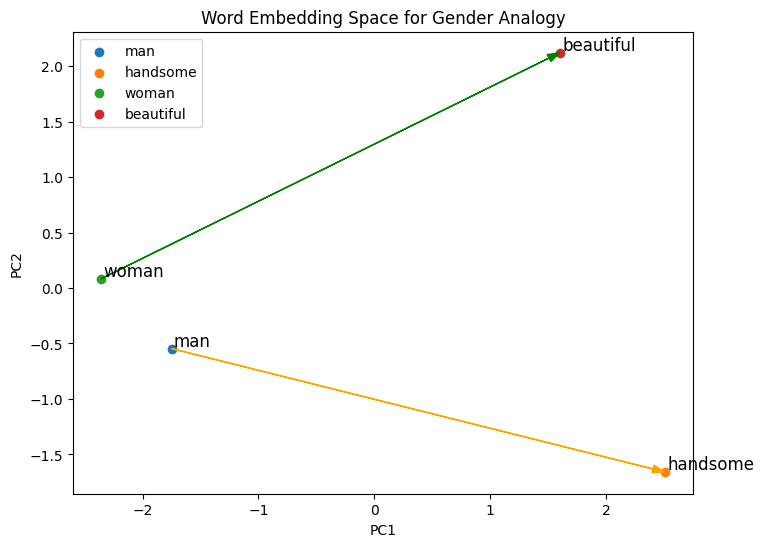

In [5]:
# Install gensim if needed: !pip install gensim
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import KeyedVectors
import gensim.downloader as api
from sklearn.decomposition import PCA

# Load pre-trained GloVe model (50-dimensional, small and fast for demo)
wv = api.load('glove-wiki-gigaword-50')

words = ["man", "handsome", "woman", "beautiful"]
embeddings = np.array([wv[word] for word in words])

# Reduce to 2D for visualization
pca = PCA(n_components=2)
embed_2d = pca.fit_transform(embeddings)

fig, ax = plt.subplots(figsize=(8, 6))
for i, word in enumerate(words):
    ax.scatter(embed_2d[i,0], embed_2d[i,1], label=word)
    ax.text(embed_2d[i,0]+0.02, embed_2d[i,1]+0.02, word, fontsize=12)

# Draw vectors man->king and woman->queen
def arrow_between(a, b, cur_color):
    ax.arrow(embed_2d[a,0], embed_2d[a,1],
             embed_2d[b,0]-embed_2d[a,0], embed_2d[b,1]-embed_2d[a,1],
             head_width=0.07, length_includes_head=True, color=cur_color)

arrow_between(0, 1, 'orange') # man to king
arrow_between(2, 3, 'green')  # woman to queen

ax.set_xlabel("PC1")
ax.set_ylabel("PC2")
ax.set_title("Word Embedding Space for Gender Analogy")
plt.legend()
plt.show()


## Softmax Function with Temperature Value

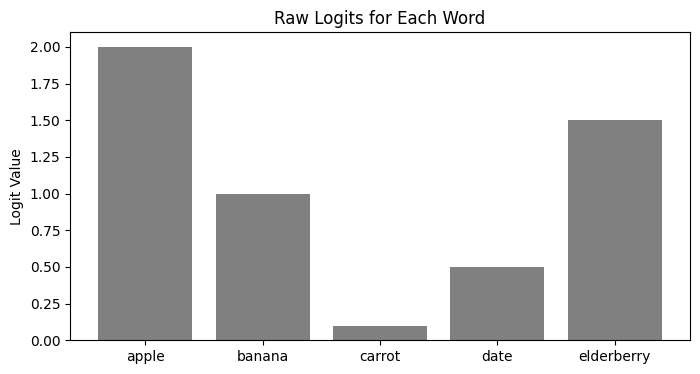

interactive(children=(IntSlider(value=1, description='Temperature (K)', max=5, min=1), Output()), _dom_classes…

<function __main__.plot_softmax(temperature)>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from ipywidgets import interact, IntSlider

# Example scores (logits) for five words
logits = np.array([2.0, 1.0, 0.1, 0.5, 1.5])
words = ['apple', 'banana', 'carrot', 'date', 'elderberry']

# Plot raw logits (unnormalized scores) as a static bar graph
plt.figure(figsize=(8, 4))
plt.bar(words, logits, color='gray')
plt.ylabel('Logit Value')
plt.title('Raw Logits for Each Word')
plt.show()

def softmax_with_temperature(logits, temperature):
    logits = logits / temperature
    logits = logits - np.max(logits)  # for numerical stability
    exp_logits = np.exp(logits)
    return exp_logits / np.sum(exp_logits)

def plot_softmax(temperature):
    if temperature < 1e-3:
        temperature = 1e-3  # Avoid division by zero
    prob = softmax_with_temperature(logits, temperature)
    plt.figure(figsize=(8, 4))
    bars = plt.bar(words, prob, color='skyblue')
    plt.ylim(0, 1)
    plt.ylabel('Probability')
    plt.title(f'Softmax Probabilities with Temperature = {temperature}')
    for bar, p in zip(bars, prob):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{p:.2f}",
                 ha='center', va='bottom')
    plt.show()

# Interactive slider for temperature (K) as an integer between 1 and 5
interact(plot_softmax,
         temperature=IntSlider(min=1, max=5, step=1, value=1, description='Temperature (K)'))

## Notebook 12.1: Self-Attention

In [7]:
import numpy as np
import matplotlib.pyplot as plt

The self-attention mechanism maps $N$ inputs $\mathbf{x}_{n}\in\mathbb{R}^{D}$ and returns $N$ outputs $\mathbf{x}'_{n}\in \mathbb{R}^{D}$.  



In [8]:
# Set seed so we get the same random numbers
np.random.seed(3)
# Number of inputs
N = 3
# Number of dimensions of each input
D = 4
# Create an empty list
all_x = []
# Create elements x_n and append to list
for n in range(N):
  all_x.append(np.random.normal(size=(D,1)))
# Print out the list
print(all_x)


[array([[ 1.78862847],
       [ 0.43650985],
       [ 0.09649747],
       [-1.8634927 ]]), array([[-0.2773882 ],
       [-0.35475898],
       [-0.08274148],
       [-0.62700068]]), array([[-0.04381817],
       [-0.47721803],
       [-1.31386475],
       [ 0.88462238]])]


We'll also need the weights and biases for the keys, queries, and values (equations 12.2 and 12.4)

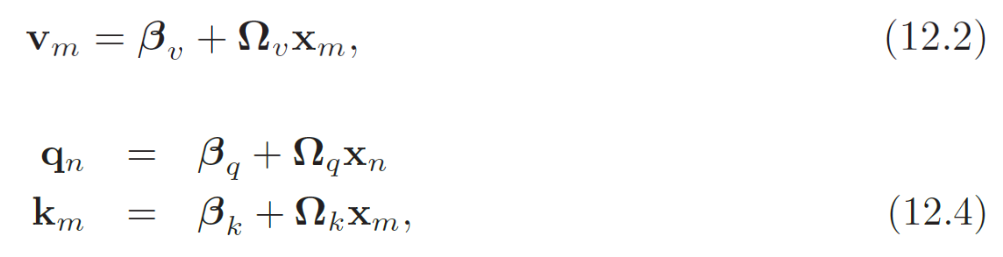

In [9]:
# Set seed so we get the same random numbers
np.random.seed(0)

# Choose random values for the parameters
omega_q = np.random.normal(size=(D,D))
omega_k = np.random.normal(size=(D,D))
omega_v = np.random.normal(size=(D,D))
beta_q = np.random.normal(size=(D,1))
beta_k = np.random.normal(size=(D,1))
beta_v = np.random.normal(size=(D,1))

Now let's compute the queries, keys, and values for each input

In [10]:
# Make three lists to store queries, keys, and values
all_queries = []
all_keys = []
all_values = []
# For every input
for x in all_x:

  # TODO -- compute the keys, queries and values.
  query = None
  key = None
  value = None

  all_queries.append(query)
  all_keys.append(key)
  all_values.append(value)

We'll need a softmax function (equation 12.5) -- here, it will take a list of arbitrary numbers and return a list where the elements are non-negative and sum to one

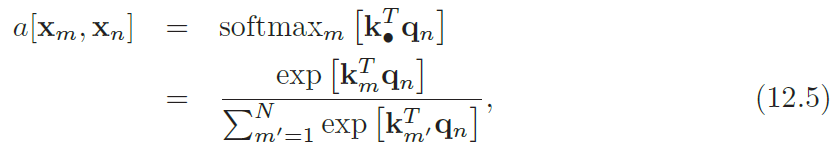

In [11]:
def softmax(items_in):
  # TODO Compute the elements of items_out
  items_out = None

  return items_out

Now compute the self attention values:
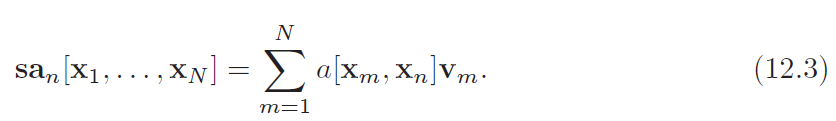

Alternative equation used here:

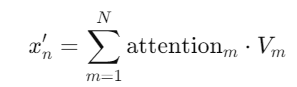

In [13]:
# Create emptymlist for output
all_x_prime = []

# For each output
for n in range(N):
  # Create list for dot products of query N with all keys
  all_km_qn = []
  # Compute the dot products
  for key in all_keys:
    # TODO -- compute the appropriate dot product
    # Replace this line
    dot_product = None

    # Store dot product
    all_km_qn.append(dot_product)

  # Compute dot product
  attention = softmax(all_km_qn)
  # Print result (should be positive sum to one)
  print("Attentions for output ", n)
  print(attention)

  # TODO: Compute a weighted sum of all of the values according to the attention
  # (equation 12.3)
  # Replace this line
  x_prime = None

  all_x_prime.append(x_prime)


# Print out true values to check you have it correct
print("x_prime_0_calculated:", all_x_prime[0].transpose())
print("x_prime_0_true: [[ 0.94744244 -0.24348429 -0.91310441 -0.44522983]]")
print("x_prime_1_calculated:", all_x_prime[1].transpose())
print("x_prime_1_true: [[ 1.64201168 -0.08470004  4.02764044  2.18690791]]")
print("x_prime_2_calculated:", all_x_prime[2].transpose())
print("x_prime_2_true: [[ 1.61949281 -0.06641533  3.96863308  2.15858316]]")


Attentions for output  0
None
Attentions for output  1
None
Attentions for output  2
None


AttributeError: 'NoneType' object has no attribute 'transpose'

In [14]:
import numpy as np

# Set seed so we get the same random numbers
np.random.seed(3)

# Number of inputs
N = 3
# Number of dimensions of each input
D = 4

# Create an empty list
all_x = []
# Create elements x_n and append to list
for n in range(N):
    all_x.append(np.random.normal(size=(D, 1)))

# Print out the list
print(all_x)

# Set seed for parameter initialization
np.random.seed(0)

# Choose random values for the parameters
omega_q = np.random.normal(size=(D, D))
omega_k = np.random.normal(size=(D, D))
omega_v = np.random.normal(size=(D, D))
beta_q = np.random.normal(size=(D, 1))
beta_k = np.random.normal(size=(D, 1))
beta_v = np.random.normal(size=(D, 1))

# Make three lists to store queries, keys, and values
all_queries = []
all_keys = []
all_values = []

# For every input
for x in all_x:
    # compute the keys, queries and values
    query = omega_q @ x + beta_q
    key = omega_k @ x + beta_k
    value = omega_v @ x + beta_v

    all_queries.append(query)
    all_keys.append(key)
    all_values.append(value)

def softmax(items_in):
    # Stable softmax over a 1D list/array of scalars
    z = np.array(items_in, dtype=float).reshape(-1)
    z -= np.max(z)
    e = np.exp(z)
    return e / np.sum(e)

# Create empty list for output
all_x_prime = []

# For each output
for n in range(N):
    # Create list for dot products of query n with all keys
    all_km_qn = []

    # Compute the dot products
    qn = all_queries[n]
    for key in all_keys:
        # scalar dot product q_n^T k_m
        dot_product = float(qn.T @ key)
        all_km_qn.append(dot_product)

    # Compute attention weights
    attention = softmax(all_km_qn)

    # Print result (should be positive and sum to one)
    print("Attentions for output ", n)
    print(attention)

    # Compute a weighted sum of all of the values according to the attention
    x_prime = sum(attention[m] * all_values[m] for m in range(N))

    all_x_prime.append(x_prime)

# Print out values to check correctness
print("x_prime_0_calculated:", all_x_prime[0].transpose())
print("x_prime_0_true: [[ 0.94744244 -0.24348429 -0.91310441 -0.44522983]]")
print("x_prime_1_calculated:", all_x_prime[1].transpose())
print("x_prime_1_true: [[ 1.64201168 -0.08470004  4.02764044  2.18690791]]")
print("x_prime_2_calculated:", all_x_prime[2].transpose())
print("x_prime_2_true: [[ 1.61949281 -0.06641533  3.96863308  2.15858316]]")


[array([[ 1.78862847],
       [ 0.43650985],
       [ 0.09649747],
       [-1.8634927 ]]), array([[-0.2773882 ],
       [-0.35475898],
       [-0.08274148],
       [-0.62700068]]), array([[-0.04381817],
       [-0.47721803],
       [-1.31386475],
       [ 0.88462238]])]
Attentions for output  0
[1.24326146e-13 9.98281489e-01 1.71851130e-03]
Attentions for output  1
[2.79525306e-12 5.85506360e-03 9.94144936e-01]
Attentions for output  2
[0.00505708 0.00654776 0.98839516]
x_prime_0_calculated: [[ 0.94744244 -0.24348429 -0.91310441 -0.44522983]]
x_prime_0_true: [[ 0.94744244 -0.24348429 -0.91310441 -0.44522983]]
x_prime_1_calculated: [[ 1.64201168 -0.08470004  4.02764044  2.18690791]]
x_prime_1_true: [[ 1.64201168 -0.08470004  4.02764044  2.18690791]]
x_prime_2_calculated: [[ 1.61949281 -0.06641533  3.96863308  2.15858316]]
x_prime_2_true: [[ 1.61949281 -0.06641533  3.96863308  2.15858316]]


/tmp/ipython-input-4276931805.py:66: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  dot_product = float(qn.T @ key)


Now let's compute the same thing, but using matrix calculations.  We'll store the $N$ inputs $\mathbf{x}_{n}\in\mathbb{R}^{D}$ in the columns of a $D\times N$ matrix, using equations 12.6 and 12.7/8.

Note:  The book uses column vectors (for compatibility with the rest of the text), but in the wider literature it is more normal to store the inputs in the rows of a matrix;  in this case, the computation is the same, but all the matrices are transposed and the operations proceed in the reverse order.
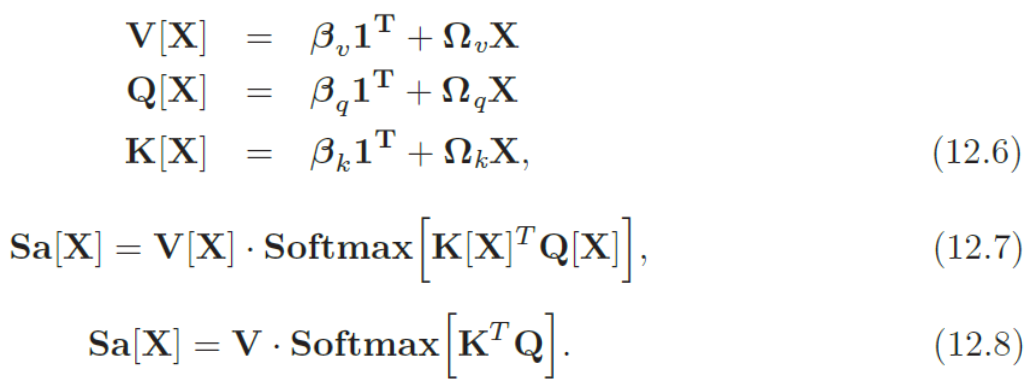


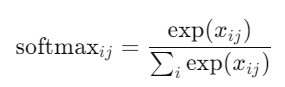

In [15]:
# Define softmax operation that works independently on each column
def softmax_cols(data_in):
  # Exponentiate all of the values
  exp_values = np.exp(data_in) ;
  # Sum over columns
  denom = np.sum(exp_values, axis = 0);
  # Replicate denominator to N rows
  denom = np.matmul(np.ones((data_in.shape[0],1)), denom[np.newaxis,:])
  # Compute softmax
  softmax = exp_values / denom
  # return the answer
  return softmax

In [16]:
 # Now let's compute self attention in matrix form
def self_attention(X,omega_v, omega_q, omega_k, beta_v, beta_q, beta_k):

  # TODO -- Write this function
  # 1. Compute queries, keys, and values
  # 2. Compute dot products
  # 3. Apply softmax to calculate attentions
  # 4. Weight values by attentions

  # Replace this line
  X_prime = None


  return X_prime

In [17]:
# Copy data into matrix
X = np.zeros((D, N))
X[:,0] = np.squeeze(all_x[0])
X[:,1] = np.squeeze(all_x[1])
X[:,2] = np.squeeze(all_x[2])

# Run the self attention mechanism
X_prime = self_attention(X,omega_v, omega_q, omega_k, beta_v, beta_q, beta_k)

# Print out the results
print(X_prime)

None


In [18]:
# Define softmax operation that works independently on each column
def softmax_cols(data_in):
    # Exponentiate all of the values (stable: subtract col max)
    shifted = data_in - np.max(data_in, axis=0, keepdims=True)
    exp_values = np.exp(shifted)
    denom = np.sum(exp_values, axis=0, keepdims=True)
    return exp_values / denom

# Compute self attention in matrix form
def self_attention(X, omega_v, omega_q, omega_k, beta_v, beta_q, beta_k):
    """
    X:        (D, N) input matrix with N vectors (columns) of dim D
    omega_*:  (D, D) weight matrices
    beta_*:   (D, 1) bias vectors
    Returns:
      X_prime: (D, N) attention outputs
    """

    # 1) Compute queries, keys, values (affine transforms applied to each column)
    ones_row = np.ones((1, X.shape[1]))          # (1, N)
    Q = omega_q @ X + beta_q @ ones_row          # (D, N)
    K = omega_k @ X + beta_k @ ones_row          # (D, N)
    V = omega_v @ X + beta_v @ ones_row          # (D, N)

    # 2) Compute dot products for all query-key pairs (keys vs queries)
    #    scores[m, n] = k_m^T q_n  -> (N, N) = (N, D) @ (D, N)
    scores = K.T @ Q                               # (N, N)

    # 3) Apply column-wise softmax to get attentions for each query n over keys m
    A = softmax_cols(scores)                       # (N, N)

    # 4) Weight values by attentions: x'_n = sum_m A[m, n] * v_m
    X_prime = V @ A                                # (D, N)

    return X_prime

# Copy data into matrix
X = np.zeros((D, N))
X[:, 0] = np.squeeze(all_x[0])
X[:, 1] = np.squeeze(all_x[1])
X[:, 2] = np.squeeze(all_x[2])

# Run the self attention mechanism
X_prime = self_attention(X, omega_v, omega_q, omega_k, beta_v, beta_q, beta_k)

# Print out the results
print(X_prime)


[[ 0.94744244  1.64201168  1.61949281]
 [-0.24348429 -0.08470004 -0.06641533]
 [-0.91310441  4.02764044  3.96863308]
 [-0.44522983  2.18690791  2.15858316]]


If you did this correctly, the values should be the same as above.

TODO:  

Print out the attention matrix
You will see that the values are quite extreme (one is very close to one and the others are very close to zero.  Now we'll fix this problem by using scaled dot-product attention.

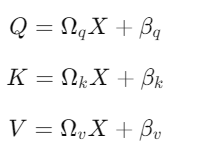

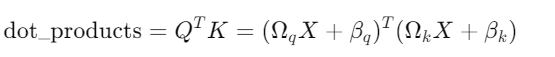

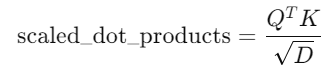

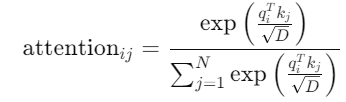

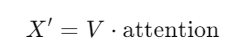


The combined equation:

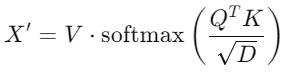

In [19]:
import numpy as np

# We'll reuse the stable column-wise softmax from before
def softmax_cols(data_in):
    shifted = data_in - np.max(data_in, axis=0, keepdims=True)
    exp_values = np.exp(shifted)
    denom = np.sum(exp_values, axis=0, keepdims=True)
    return exp_values / denom

# Scaled dot-product self attention (with printing of attention matrices)
def scaled_dot_product_self_attention(X, omega_v, omega_q, omega_k, beta_v, beta_q, beta_k):
    """
    X:        (D, N) with N column vectors of dim D
    Returns:
      X_prime: (D, N) attention outputs using scaled dot-product attention
      A_unscaled: (N, N) attention weights from unscaled scores (for comparison)
      A_scaled:   (N, N) attention weights from scaled scores (the fix)
    """
    D, N = X.shape
    ones_row = np.ones((1, N))

    # 1) Queries, keys, values
    Q = omega_q @ X + beta_q @ ones_row     # (D, N)
    K = omega_k @ X + beta_k @ ones_row     # (D, N)
    V = omega_v @ X + beta_v @ ones_row     # (D, N)

    # 2) Dot products (scores[m, n] = k_m^T q_n)
    scores = K.T @ Q                         # (N, N)

    # ----- Show the "problem": unscaled attention -----
    A_unscaled = softmax_cols(scores)        # very peaky
    print("Unscaled attention matrix (columns sum to 1):")
    print(A_unscaled)

    # 3) Scale the dot products by sqrt(D) (eq. 12.9)
    scale = 1.0 / np.sqrt(D)
    scores_scaled = scores * scale

    # 4) Softmax over scaled scores
    A_scaled = softmax_cols(scores_scaled)

    # 5) Weighted sum of values by attentions
    X_prime = V @ A_scaled

    return X_prime, A_unscaled, A_scaled


# ---- Run the mechanism and print results ----
X_prime, A_unscaled, A_scaled = scaled_dot_product_self_attention(
    X, omega_v, omega_q, omega_k, beta_v, beta_q, beta_k
)

# Outputs
print("\nX_prime (scaled dot-product attention):")
print(X_prime)

print("\nScaled attention matrix (columns sum to 1):")
print(A_scaled)


Unscaled attention matrix (columns sum to 1):
[[1.24326146e-13 2.79525306e-12 5.05707907e-03]
 [9.98281489e-01 5.85506360e-03 6.54776072e-03]
 [1.71851130e-03 9.94144936e-01 9.88395160e-01]]

X_prime (scaled dot-product attention):
[[ 0.97411966  1.59622051  1.32638014]
 [-0.23738409 -0.09516106  0.13062402]
 [-0.72333202  3.70194096  3.02371664]
 [-0.34413007  2.01339538  1.6902419 ]]

Scaled attention matrix (columns sum to 1):
[[3.38843552e-07 1.55730194e-06 6.20418746e-02]
 [9.60161968e-01 7.12734969e-02 7.05962187e-02]
 [3.98376935e-02 9.28724946e-01 8.67361907e-01]]


TODO -- Investigate whether the self-attention mechanism is covariant with respect to permutation.
If it is, when we permute the columns of the input matrix $\mathbf{X}$, the columns of the output matrix $\mathbf{X}'$ will also be permuted.


In [20]:
# Make a random permutation of columns
perm = np.random.permutation(N)
P = np.eye(N)[:, perm]      # permutation matrix (N x N)

# Original outputs
Xprime = self_attention(X, omega_v, omega_q, omega_k, beta_v, beta_q, beta_k)

# Permute inputs and run again
X_perm = X @ P
Xprime_perm = self_attention(X_perm, omega_v, omega_q, omega_k, beta_v, beta_q, beta_k)

# Compare: should match Xprime @ P (up to tiny numerical error)
print(np.allclose(Xprime_perm, Xprime @ P, atol=1e-8))

True
